In [28]:
import pandas as pd
import numpy as np
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from scipy.stats import loguniform
# from pandas import read_csv
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from qkeras import *
today = datetime.date(datetime.now())
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights

In [29]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [30]:
#outdir = "/global/homes/e/elham/rnn_hls4ml/results/"
outpath = "gru_training_2022-08-09"
#comd = "mkdir "+outpath
#os.system(comd)

In [31]:
# inputdir = 'rnn_hls4ml_data_scaled'
inputdir = 'rnn_hls4ml_data_scaled_2class'

y-shape:  (379052, 1)
x-shape:  (379052, 20, 6)


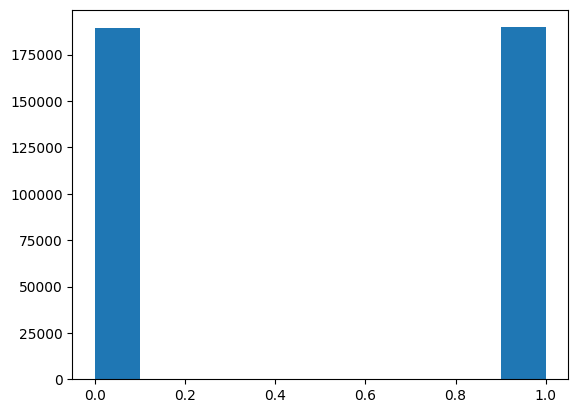

In [32]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

y_train = y_train[:,4:5]
plt.hist(y_train)

print("y-shape: ", y_train.shape)
print("x-shape: ", x_train.shape)

In [33]:
x_test = np.load('./x_test.npy')
y_test = np.load('./y_test.npy')

## Small GRU

In [7]:
model = Sequential()
model.add(GRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
              name = 'layer1', input_shape = (20,6)))
model.add(Dense(5, activation='relu', kernel_initializer='glorot_normal', name='layer2'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

2022-06-23 10:17:30.501174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 5)                 195       
                                                                 
 layer2 (Dense)              (None, 5)                 30        
                                                                 
 output_sigmoid (Dense)      (None, 1)                 6         
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


## Small QGRU

In [40]:
qmodel = Sequential()
qmodel.add(QGRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
                name = 'layer1', kernel_quantizer=quantized_bits(2,0,alpha=1),
                recurrent_quantizer=quantized_bits(2,0,alpha=1) , bias_quantizer=quantized_bits(2,0,alpha=1),
                state_quantizer=quantized_bits(2,0,alpha=1) ,input_shape = (20,6)))
qmodel.add(QDense(5, activation='relu', kernel_initializer='glorot_normal', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name='layer2'))
qmodel.add(QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name = 'output_sigmoid'))
qmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 5)                 180       
                                                                 
 layer2 (QDense)             (None, 5)                 30        
                                                                 
 output_sigmoid (QDense)     (None, 1)                 6         
                                                                 
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


## GRU

In [34]:
model = Sequential()
model.add(GRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001), name = 'layer1', input_shape = (20,6)))
model.add(Dense(64,  kernel_initializer='glorot_normal', name='layer3')) #kernel_regularizer = regularizers.l1_l2(l1= 0.0001, l2 = 0.0001),
model.add(Activation('relu', name = 'relu_0'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 20)                1680      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 relu_0 (Activation)         (None, 64)                0         
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


## GRU Training

In [26]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**10,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'gru/model_gru.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
        
labels = ['j_t']
y_keras = model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
297/297 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.7547
Epoch 1: val_loss improved from inf to 0.38766, saving model to gru\model_gru.h5
297/297 [==============================] - 4s 8ms/step - loss: 0.5157 - accuracy: 0.7547 - val_loss: 0.3877 - val_accuracy: 0.8408
Epoch 2/150
295/297 [============================>.] - ETA: 0s - loss: 0.3905 - accuracy: 0.8391
Epoch 2: val_loss improved from 0.38766 to 0.38110, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3905 - accuracy: 0.8391 - val_loss: 0.3811 - val_accuracy: 0.8433
Epoch 3/150
297/297 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8418
Epoch 3: val_loss did not improve from 0.38110
297/297 [==============================] - 2s 6ms/step - loss: 0.3848 - accuracy: 0.8418 - val_loss: 0.3998 - val_accuracy: 0.8336
Epoch 4/150
297/297 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8422
Epoch 

Epoch 58/150
286/297 [===========================>..] - ETA: 0s - loss: 0.3493 - accuracy: 0.8553
Epoch 58: val_loss did not improve from 0.34268
297/297 [==============================] - 2s 6ms/step - loss: 0.3493 - accuracy: 0.8553 - val_loss: 0.3447 - val_accuracy: 0.8580
Epoch 59/150
290/297 [============================>.] - ETA: 0s - loss: 0.3477 - accuracy: 0.8555
Epoch 59: val_loss improved from 0.34268 to 0.34178, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3475 - accuracy: 0.8556 - val_loss: 0.3418 - val_accuracy: 0.8588
Epoch 60/150
295/297 [============================>.] - ETA: 0s - loss: 0.3475 - accuracy: 0.8552
Epoch 60: val_loss did not improve from 0.34178
297/297 [==============================] - 2s 6ms/step - loss: 0.3475 - accuracy: 0.8552 - val_loss: 0.3422 - val_accuracy: 0.8589
Epoch 61/150
288/297 [============================>.] - ETA: 0s - loss: 0.3464 - accuracy: 0.8558
Epoch 61: val_loss did not improv

Epoch 87/150
296/297 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8581
Epoch 87: val_loss improved from 0.33715 to 0.33665, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3424 - accuracy: 0.8581 - val_loss: 0.3366 - val_accuracy: 0.8611
Epoch 88/150
289/297 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8578
Epoch 88: val_loss did not improve from 0.33665
297/297 [==============================] - 2s 6ms/step - loss: 0.3426 - accuracy: 0.8577 - val_loss: 0.3438 - val_accuracy: 0.8582
Epoch 89/150
290/297 [============================>.] - ETA: 0s - loss: 0.3425 - accuracy: 0.8575
Epoch 89: val_loss did not improve from 0.33665
297/297 [==============================] - 2s 6ms/step - loss: 0.3426 - accuracy: 0.8574 - val_loss: 0.3419 - val_accuracy: 0.8590
Epoch 90/150
295/297 [============================>.] - ETA: 0s - loss: 0.3432 - accuracy: 0.8574
Epoch 90: val_loss did not improv

293/297 [============================>.] - ETA: 0s - loss: 0.3402 - accuracy: 0.8587
Epoch 116: val_loss did not improve from 0.33581
297/297 [==============================] - 2s 6ms/step - loss: 0.3401 - accuracy: 0.8588 - val_loss: 0.3373 - val_accuracy: 0.8609
Epoch 117/150
292/297 [============================>.] - ETA: 0s - loss: 0.3404 - accuracy: 0.8581
Epoch 117: val_loss did not improve from 0.33581
297/297 [==============================] - 2s 6ms/step - loss: 0.3405 - accuracy: 0.8580 - val_loss: 0.3365 - val_accuracy: 0.8617
Epoch 118/150
292/297 [============================>.] - ETA: 0s - loss: 0.3394 - accuracy: 0.8589
Epoch 118: val_loss improved from 0.33581 to 0.33533, saving model to gru\model_gru.h5
297/297 [==============================] - 2s 6ms/step - loss: 0.3396 - accuracy: 0.8588 - val_loss: 0.3353 - val_accuracy: 0.8612
Epoch 119/150
296/297 [============================>.] - ETA: 0s - loss: 0.3387 - accuracy: 0.8589
Epoch 119: val_loss did not improve from

Epoch 145/150
291/297 [============================>.] - ETA: 0s - loss: 0.3362 - accuracy: 0.8603
Epoch 145: val_loss did not improve from 0.33264
297/297 [==============================] - 2s 5ms/step - loss: 0.3364 - accuracy: 0.8603 - val_loss: 0.3381 - val_accuracy: 0.8593
Epoch 146/150
289/297 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8599
Epoch 146: val_loss did not improve from 0.33264
297/297 [==============================] - 2s 5ms/step - loss: 0.3363 - accuracy: 0.8598 - val_loss: 0.3417 - val_accuracy: 0.8585
Epoch 147/150
293/297 [============================>.] - ETA: 0s - loss: 0.3361 - accuracy: 0.8601
Epoch 147: val_loss did not improve from 0.33264
297/297 [==============================] - 2s 5ms/step - loss: 0.3360 - accuracy: 0.8602 - val_loss: 0.3329 - val_accuracy: 0.8617
Epoch 148/150
294/297 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8605
Epoch 148: val_loss improved from 0.33264 to 0.33258, saving mod

## Check GRU Weight

In [71]:
gru = load_model('gru/model_gru.h5')
for layer in gru.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

layer1 [array([[ 3.85863095e-04, -4.31572989e-05, -8.73781159e-04,
        -1.92459358e-03,  1.29464571e-03, -7.83140678e-03,
        -4.52704169e-03, -3.65656661e-03, -3.18534370e-03,
         3.37608485e-03,  3.79501667e-04,  1.43090059e-04,
        -2.91849719e-04,  8.80206935e-04,  1.11935418e-02,
        -8.25973451e-02,  9.25967994e-04,  3.15461159e-02,
         1.89862424e-03, -9.26391571e-04,  1.34568941e-03,
        -3.21646483e-04, -3.17244732e-04,  9.94211645e-04,
        -1.33366417e-03, -9.53792632e-02,  5.20681147e-04,
        -6.92073663e-04, -5.64584276e-04,  2.83501897e-04,
        -1.50891044e-03, -8.75553465e-04,  1.81423943e-03,
        -1.65851277e-04,  1.15897600e-03,  1.42314332e-03,
        -2.79614981e-03,  3.73507763e-04, -2.02249549e-03,
        -1.82630494e-04, -3.94495055e-02,  8.40177685e-02,
        -7.14575201e-02,  4.64393914e-01, -6.57469153e-01,
        -6.35456562e-01,  4.78052169e-01, -2.35041808e-02,
         2.84459330e-02,  3.76566380e-01,  6.809

## LSTM

In [18]:
model = Sequential()
model.add(LSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
               name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', name='layer3'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 20)                2160      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 256,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'lstm/model_lstm.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
labels = ['j_t']
y_keras = model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

# print(history.history.keys())
#     # summarize history for accuracy
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# print(history.history.keys())
#     # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

## LSTM weight

In [73]:
lstm = load_model('lstm/model_toptag_lstm.h5')
for layer in lstm.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

layer1 [array([[ 7.39419879e-03, -5.83838159e-03,  3.01538318e-01,
         1.71923459e-01,  6.68122293e-03,  2.97626834e-02,
         3.32187265e-01,  1.97732152e-04, -2.47867294e-02,
        -2.70899326e-01,  2.38649055e-01, -1.53928593e-01,
        -2.45593235e-01, -4.70351195e-03, -4.40326781e-04,
        -9.93248895e-02, -4.17812057e-02,  1.16892830e-02,
         3.17993254e-05, -1.51097625e-01,  1.57310724e-01,
         3.35737281e-02,  1.41706407e-01, -2.90701236e-03,
        -1.97995920e-03, -2.25614622e-01, -1.60605669e-01,
         4.88352962e-04, -7.87862241e-02,  1.11477904e-01,
        -2.62344658e-01, -4.76501277e-03, -1.96079127e-02,
        -1.55211061e-01,  4.44040663e-04, -2.17573345e-02,
        -1.32157400e-01,  3.02360058e-02,  1.89535355e-03,
         1.29000042e-02,  1.78925186e-01,  1.04064144e-01,
         4.50133756e-02,  3.35197598e-01,  7.82899320e-01,
        -6.99297264e-02, -2.05348253e-01,  4.42941576e-01,
         5.70073307e-01,  1.53039768e-01, -3.163

## Quantization Aware Training

## QGRU

In [27]:
GRU_2int = []
GRU_4int = []
for j in [1]:
    for i in [2]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
        qmodel.summary()
        
        es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=20)
        adam = Adam(lr = 0.0002)
    
        qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'qgru_{j}int_test3/model_qgru_{i}frac.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
        if j == 2:
            GRU_2int.append(auc_score)
        else:
            GRU_4int.append(auc_score)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 20)                1680      
                                                                 
 layer3 (QDense)             (None, 64)                1344      
                                                                 
 relu_0 (QActivation)        (None, 64)                0         
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
19/19 [==============================] - ETA: 0s - loss: 2.2782 - accuracy: 0.5576
Epoch 1: val_loss improved from inf to 3.56175, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 10s 287ms/step - loss: 2.2782 - accuracy: 0.5576 - val_loss: 3.5617 - val_accuracy: 0.5960
Epoch 2/150
19/19 [==============================] - ETA: 0s - loss: 3.2003 - accuracy: 0.6003
Epoch 2: val_loss improved from 3.56175 to 2.77085, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 154ms/step - loss: 3.2003 - accuracy: 0.6003 - val_loss: 2.7708 - val_accuracy: 0.6462
Epoch 3/150
19/19 [==============================] - ETA: 0s - loss: 3.1697 - accuracy: 0.6375
Epoch 3: val_loss improved from 2.77085 to 1.97440, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 146ms/step - loss: 3.1697 - accuracy: 0.6375 - val_loss: 1.9744 - val_accuracy: 0.6920
Epoch 4/150
1

Epoch 29/150
19/19 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 0.6694
Epoch 29: val_loss improved from 0.72448 to 0.70587, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 150ms/step - loss: 0.9316 - accuracy: 0.6694 - val_loss: 0.7059 - val_accuracy: 0.6538
Epoch 30/150
19/19 [==============================] - ETA: 0s - loss: 0.8116 - accuracy: 0.6832
Epoch 30: val_loss did not improve from 0.70587
19/19 [==============================] - 3s 143ms/step - loss: 0.8116 - accuracy: 0.6832 - val_loss: 0.8566 - val_accuracy: 0.6439
Epoch 31/150
19/19 [==============================] - ETA: 0s - loss: 0.9428 - accuracy: 0.6729
Epoch 31: val_loss improved from 0.70587 to 0.70313, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 146ms/step - loss: 0.9428 - accuracy: 0.6729 - val_loss: 0.7031 - val_accuracy: 0.6846
Epoch 32/150
19/19 [==============================] - ETA: 0s

Epoch 58/150
19/19 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.7334
Epoch 58: val_loss did not improve from 0.63306
19/19 [==============================] - 3s 144ms/step - loss: 0.7522 - accuracy: 0.7334 - val_loss: 0.8191 - val_accuracy: 0.7490
Epoch 59/150
19/19 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7316
Epoch 59: val_loss improved from 0.63306 to 0.62314, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 151ms/step - loss: 0.7625 - accuracy: 0.7316 - val_loss: 0.6231 - val_accuracy: 0.7359
Epoch 60/150
19/19 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.7264
Epoch 60: val_loss did not improve from 0.62314
19/19 [==============================] - 3s 142ms/step - loss: 0.7789 - accuracy: 0.7264 - val_loss: 0.7184 - val_accuracy: 0.7320
Epoch 61/150
19/19 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.7420
Epoch 61: val_loss did

19/19 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.7624
Epoch 87: val_loss improved from 0.61568 to 0.60901, saving model to qgru_1int_test3\model_qgru_2frac.h5
19/19 [==============================] - 3s 145ms/step - loss: 0.7633 - accuracy: 0.7624 - val_loss: 0.6090 - val_accuracy: 0.7430
Epoch 88/150
19/19 [==============================] - ETA: 0s - loss: 0.7380 - accuracy: 0.7510
Epoch 88: val_loss did not improve from 0.60901
19/19 [==============================] - 3s 144ms/step - loss: 0.7380 - accuracy: 0.7510 - val_loss: 0.8220 - val_accuracy: 0.7391
Epoch 89/150
19/19 [==============================] - ETA: 0s - loss: 0.8572 - accuracy: 0.7361
Epoch 89: val_loss did not improve from 0.60901
19/19 [==============================] - 3s 155ms/step - loss: 0.8572 - accuracy: 0.7361 - val_loss: 0.7110 - val_accuracy: 0.6999
Epoch 90/150
19/19 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.7322
Epoch 90: val_loss did not improve 

19/19 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.7761
Epoch 116: val_loss did not improve from 0.59503
19/19 [==============================] - 3s 146ms/step - loss: 0.7233 - accuracy: 0.7761 - val_loss: 0.7838 - val_accuracy: 0.7488
Epoch 117/150
19/19 [==============================] - ETA: 0s - loss: 0.7361 - accuracy: 0.7769
Epoch 117: val_loss did not improve from 0.59503
19/19 [==============================] - 3s 146ms/step - loss: 0.7361 - accuracy: 0.7769 - val_loss: 0.6320 - val_accuracy: 0.7816
Epoch 118/150
19/19 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.7720
Epoch 118: val_loss did not improve from 0.59503
19/19 [==============================] - 3s 148ms/step - loss: 0.7397 - accuracy: 0.7720 - val_loss: 0.6192 - val_accuracy: 0.7748
Epoch 119/150
19/19 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.7697
Epoch 119: val_loss did not improve from 0.59503
19/19 [==============================

Epoch 145/150
19/19 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7926
Epoch 145: val_loss did not improve from 0.54180
19/19 [==============================] - 3s 140ms/step - loss: 0.6553 - accuracy: 0.7926 - val_loss: 0.6192 - val_accuracy: 0.7867
Epoch 146/150
19/19 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7879
Epoch 146: val_loss did not improve from 0.54180
19/19 [==============================] - 3s 140ms/step - loss: 0.6711 - accuracy: 0.7879 - val_loss: 0.7671 - val_accuracy: 0.8053
Epoch 147/150
19/19 [==============================] - ETA: 0s - loss: 0.7114 - accuracy: 0.7921
Epoch 147: val_loss did not improve from 0.54180
19/19 [==============================] - 3s 139ms/step - loss: 0.7114 - accuracy: 0.7921 - val_loss: 0.6813 - val_accuracy: 0.7932
Epoch 148/150
19/19 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.7944
Epoch 148: val_loss did not improve from 0.54180
19/19 [================

In [36]:
GRU_2int = [0.8889239320342668, 0.9130811006719319, 0.9166560291073371, 0.9166675510362661, 0.9184637408665223, 0.9156683138854429, 0.911016851381327]

In [37]:
GRU_4int = [0.8968693044839106, 0.9138026005450852, 0.9159394334655987, 0.9175075966343627, 0.9139816954386266, 0.9055667277565066, 0.8972966007204316]

(0.5, 0.95)

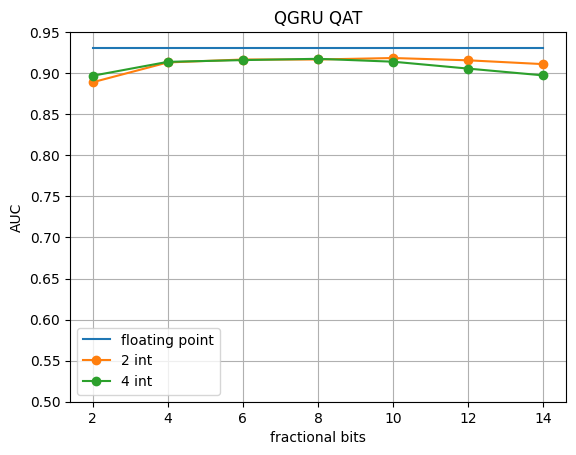

In [63]:
float_gru = [0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996]
plt.plot([2,4,6,8,10,12,14], float_gru, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], GRU_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], GRU_4int, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU QAT")
plt.grid()
plt.ylim([0.5, 0.95]) 

## QGRU weight

In [76]:
qgru = load_model('qgru_2int_test3/model_qgru_2frac.h5', custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qgru, f"gru2int2fra_weight")

... quantizing model


{'layer1': {'weights': [array([[ 0.34375   ,  0.15625   , -0.15625   , -0.28125   ,  0.1875    ,
            0.5       , -0.25      ,  0.        ,  0.375     ,  0.        ,
           -0.0625    , -0.1875    ,  0.125     ,  0.046875  , -0.21875   ,
            0.125     ,  0.625     ,  0.09375   , -0.375     , -0.03125   ,
            0.125     ,  0.        , -0.0625    , -0.15625   ,  0.        ,
           -0.125     ,  0.21875   , -0.21875   , -0.375     , -0.21875   ,
            0.        , -0.25      ,  0.125     ,  0.375     , -0.375     ,
            0.05078125, -0.125     ,  0.125     ,  0.        , -0.125     ,
            1.125     , -0.34375   ,  0.125     ,  0.125     , -0.25      ,
            0.5       ,  0.5       , -0.125     , -0.125     , -0.25      ,
           -0.28125   ,  0.4375    ,  0.625     , -0.5       , -0.5       ,
           -1.375     , -0.25      , -0.8125    , -0.3125    , -0.0625    ],
          [-0.46875   , -0.0625    , -0.40625   , -0.0625    , -0.

## QLSTM

In [48]:
# LSTM_2int = []
# LSTM_4int = []
for j in [4]:
    for i in [14]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
        qmodel.summary()
        
        es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
        adam = Adam(lr = 0.0002)
    
        qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 2**14,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'qlstm_{j}int_test3/model_qlstm_{i}frac.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
#         if j == 2:
#             LSTM_2int.append(auc_score)
#         else:
#             LSTM_4int.append(auc_score)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 20)                1680      
                                                                 
 layer3 (QDense)             (None, 64)                1344      
                                                                 
 relu_0 (QActivation)        (None, 64)                0         
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


C:\Users\cyihu\anaconda3\envs\hls4ml-tutorial\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/150
18/19 [===========================>..] - ETA: 0s - loss: 0.7056 - accuracy: 0.5032
Epoch 1: val_loss improved from inf to 0.69876, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 4s 65ms/step - loss: 0.7054 - accuracy: 0.5033 - val_loss: 0.6988 - val_accuracy: 0.5025
Epoch 2/150
17/19 [=========================>....] - ETA: 0s - loss: 0.6975 - accuracy: 0.5210
Epoch 2: val_loss improved from 0.69876 to 0.69490, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 20ms/step - loss: 0.6973 - accuracy: 0.5220 - val_loss: 0.6949 - val_accuracy: 0.5818
Epoch 3/150
17/19 [=========================>....] - ETA: 0s - loss: 0.6935 - accuracy: 0.5980
Epoch 3: val_loss improved from 0.69490 to 0.69143, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 20ms/step - loss: 0.6934 - accuracy: 0.5971 - val_loss: 0.6914 - val_accuracy: 0.6144
Epoch 4/

Epoch 27/150
16/19 [========================>.....] - ETA: 0s - loss: 0.4294 - accuracy: 0.8213
Epoch 27: val_loss did not improve from 0.41936
19/19 [==============================] - 0s 19ms/step - loss: 0.4284 - accuracy: 0.8218 - val_loss: 0.4426 - val_accuracy: 0.8190
Epoch 28/150
19/19 [==============================] - ETA: 0s - loss: 0.4229 - accuracy: 0.8229
Epoch 28: val_loss improved from 0.41936 to 0.41082, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 21ms/step - loss: 0.4229 - accuracy: 0.8229 - val_loss: 0.4108 - val_accuracy: 0.8293
Epoch 29/150
17/19 [=========================>....] - ETA: 0s - loss: 0.4146 - accuracy: 0.8296
Epoch 29: val_loss improved from 0.41082 to 0.41027, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 20ms/step - loss: 0.4149 - accuracy: 0.8295 - val_loss: 0.4103 - val_accuracy: 0.8298
Epoch 30/150
19/19 [==============================] - ETA:

Epoch 56/150
16/19 [========================>.....] - ETA: 0s - loss: 0.4138 - accuracy: 0.8341
Epoch 56: val_loss did not improve from 0.40317
19/19 [==============================] - 0s 19ms/step - loss: 0.4142 - accuracy: 0.8338 - val_loss: 0.4113 - val_accuracy: 0.8341
Epoch 57/150
17/19 [=========================>....] - ETA: 0s - loss: 0.4673 - accuracy: 0.8072
Epoch 57: val_loss did not improve from 0.40317
19/19 [==============================] - 0s 18ms/step - loss: 0.4790 - accuracy: 0.7819 - val_loss: 0.6957 - val_accuracy: 0.5007
Epoch 58/150
17/19 [=========================>....] - ETA: 0s - loss: 0.5843 - accuracy: 0.6798
Epoch 58: val_loss did not improve from 0.40317
19/19 [==============================] - 0s 19ms/step - loss: 0.5746 - accuracy: 0.6921 - val_loss: 0.4547 - val_accuracy: 0.8216
Epoch 59/150
17/19 [=========================>....] - ETA: 0s - loss: 0.4472 - accuracy: 0.8099
Epoch 59: val_loss did not improve from 0.40317
19/19 [===========================

17/19 [=========================>....] - ETA: 0s - loss: 0.3950 - accuracy: 0.8382
Epoch 83: val_loss improved from 0.39143 to 0.39101, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 19ms/step - loss: 0.3945 - accuracy: 0.8385 - val_loss: 0.3910 - val_accuracy: 0.8390
Epoch 84/150
16/19 [========================>.....] - ETA: 0s - loss: 0.3942 - accuracy: 0.8385
Epoch 84: val_loss did not improve from 0.39101
19/19 [==============================] - 0s 19ms/step - loss: 0.3940 - accuracy: 0.8388 - val_loss: 0.3942 - val_accuracy: 0.8394
Epoch 85/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3956 - accuracy: 0.8391
Epoch 85: val_loss did not improve from 0.39101
19/19 [==============================] - 0s 18ms/step - loss: 0.3957 - accuracy: 0.8388 - val_loss: 0.3911 - val_accuracy: 0.8395
Epoch 86/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3953 - accuracy: 0.8388
Epoch 86: val_loss did not improve 

Epoch 111/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3887 - accuracy: 0.8401
Epoch 111: val_loss did not improve from 0.38504
19/19 [==============================] - 0s 18ms/step - loss: 0.3883 - accuracy: 0.8403 - val_loss: 0.3851 - val_accuracy: 0.8421
Epoch 112/150
16/19 [========================>.....] - ETA: 0s - loss: 0.3870 - accuracy: 0.8411
Epoch 112: val_loss improved from 0.38504 to 0.38475, saving model to qlstm_4int_test3\model_qlstm_14frac.h5
19/19 [==============================] - 0s 20ms/step - loss: 0.3877 - accuracy: 0.8409 - val_loss: 0.3848 - val_accuracy: 0.8420
Epoch 113/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3886 - accuracy: 0.8402
Epoch 113: val_loss did not improve from 0.38475
19/19 [==============================] - 0s 18ms/step - loss: 0.3882 - accuracy: 0.8405 - val_loss: 0.3856 - val_accuracy: 0.8418
Epoch 114/150
16/19 [========================>.....] - ETA: 0s - loss: 0.3893 - accuracy: 0.8404
Epoch 114: val_

17/19 [=========================>....] - ETA: 0s - loss: 0.3875 - accuracy: 0.8397
Epoch 138: val_loss did not improve from 0.38119
19/19 [==============================] - 0s 18ms/step - loss: 0.3870 - accuracy: 0.8400 - val_loss: 0.3823 - val_accuracy: 0.8417
Epoch 139/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3854 - accuracy: 0.8410
Epoch 139: val_loss did not improve from 0.38119
19/19 [==============================] - 0s 18ms/step - loss: 0.3852 - accuracy: 0.8411 - val_loss: 0.3817 - val_accuracy: 0.8421
Epoch 140/150
19/19 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.8414
Epoch 140: val_loss did not improve from 0.38119
19/19 [==============================] - 0s 19ms/step - loss: 0.3845 - accuracy: 0.8414 - val_loss: 0.3814 - val_accuracy: 0.8422
Epoch 141/150
17/19 [=========================>....] - ETA: 0s - loss: 0.3843 - accuracy: 0.8414
Epoch 141: val_loss did not improve from 0.38119
19/19 [==============================] -

In [20]:
print(LSTM_2int)

[0.8977946415000806, 0.9074863424189847, 0.9095324922817647, 0.9204501103592764, 0.9191139183414114, 0.9154971330948511, 0.9179890956826402]


In [44]:
LSTM_2int = [0.8977946415000806, 0.9074863424189847, 0.9095324922817647, 0.9204501103592764, 0.9191139183414114, 0.9154971330948511, 0.9179890956826402]

In [49]:
LSTM_4int = [0.8991893928549448, 0.9025749104264241, 0.9195204268675183, 0.9204524318294748, 0.9198742651541856, 0.9123245878023645, 0.9057821823001705]

In [50]:
print(LSTM_4int)

[0.8991893928549448, 0.9025749104264241, 0.9195204268675183, 0.9204524318294748, 0.9198742651541856, 0.9123245878023645, 0.9057821823001705]


In [41]:
lstm = load_model('lstm/model_toptag_lstm.h5')
labels = ['j_t']
y_keras = lstm.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)

624/624 [==============================] - 2s 2ms/step
0.9207847688802558


(0.5, 0.95)

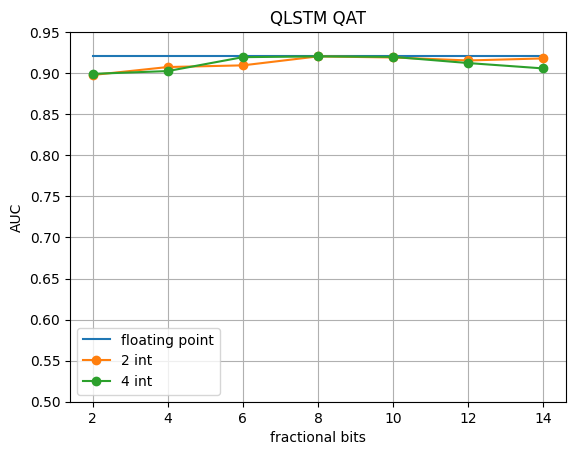

In [62]:
lstm_float = [0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558]
plt.plot([2,4,6,8,10,12,14], lstm_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], LSTM_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], LSTM_4int, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM QAT")
plt.grid()
plt.ylim([0.5, 0.95]) 

## QLSTM weight

In [75]:
qlstm = load_model('qlstm_2int_test3/model_qlstm_2frac.h5', custom_objects={'QLSTM': QLSTM, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qlstm, f"qat2int2fra_weight")

... quantizing model


{'layer1': {'weights': [array([[-0.4375  , -0.25    , -0.25    ,  0.3125  ,  0.      ,  0.      ,
           -0.3125  ,  0.125   ,  0.1875  , -0.375   , -0.25    ,  0.375   ,
            0.03125 ,  0.28125 ,  0.25    ,  0.03125 ,  0.      , -0.46875 ,
            0.0625  , -0.3125  ,  0.0625  , -0.0625  , -0.25    ,  0.1875  ,
           -0.03125 ,  0.0625  ,  0.09375 ,  0.0625  ,  0.375   ,  0.3125  ,
           -0.46875 , -0.375   ,  0.25    , -0.125   , -0.1875  , -0.375   ,
           -0.5     , -0.5625  ,  0.0625  ,  0.375   ,  0.625   , -0.375   ,
           -0.375   , -0.1875  ,  0.25    , -0.25    , -0.125   ,  0.34375 ,
           -0.5     ,  0.3125  , -0.125   ,  0.25    , -0.375   , -0.46875 ,
            0.      ,  0.0625  , -0.25    , -0.8125  , -0.1875  , -0.9375  ,
            0.125   ,  0.46875 , -0.0625  ,  0.125   ,  0.      ,  0.      ,
            0.0625  , -0.21875 ,  0.0625  ,  0.5     , -0.125   ,  0.21875 ,
           -0.1875  , -0.0625  ,  0.125   , -0.0625  , 

## Post Training Quantization

## QGRU

In [55]:
gru = load_model('gru/model_gru.h5')

In [58]:
GRU_2intptq = []
GRU_4intptq = []
for j in [2, 4]:
    for i in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(gru, config, total_bits, transfer_weights=True)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
        if j == 2:
            GRU_2intptq.append(auc_score)
        else:
            GRU_4intptq.append(auc_score)

624/624 [==============================] - 37s 57ms/step
0.5944767470490294
624/624 [==============================] - 39s 60ms/step
0.547488069753607
624/624 [==============================] - 37s 58ms/step
0.8398998982050393
624/624 [==============================] - 36s 57ms/step
0.892549626299576
624/624 [==============================] - 38s 58ms/step
0.8163931733581085
624/624 [==============================] - 37s 58ms/step
0.817795160464241
624/624 [==============================] - 37s 58ms/step
0.8192396023359739
624/624 [==============================] - 37s 58ms/step
0.563519484692306
624/624 [==============================] - 40s 62ms/step
0.5176656947846756
624/624 [==============================] - 41s 63ms/step
0.8434171918716625
624/624 [==============================] - 40s 62ms/step
0.8148832529622261
624/624 [==============================] - 40s 63ms/step
0.8185849477399875
624/624 [==============================] - 41s 63ms/step
0.8981746641616495
624/624 [=======

In [59]:
print(GRU_2intptq)

[0.5944767470490294, 0.547488069753607, 0.8398998982050393, 0.892549626299576, 0.8163931733581085, 0.817795160464241, 0.8192396023359739]


In [ ]:
GRU_2intptq = [0.5944767470490294, 0.547488069753607, 0.8398998982050393, 0.892549626299576, 0.8163931733581085, 0.817795160464241, 0.8192396023359739]

In [60]:
print(GRU_4intptq)

[0.563519484692306, 0.5176656947846756, 0.8434171918716625, 0.8148832529622261, 0.8185849477399875, 0.8981746641616495, 0.8994407397397951]


In [ ]:
GRU_4intptq = [0.563519484692306, 0.5176656947846756, 0.8434171918716625, 0.8148832529622261, 0.8185849477399875, 0.8981746641616495, 0.8994407397397951]

(0.5, 0.95)

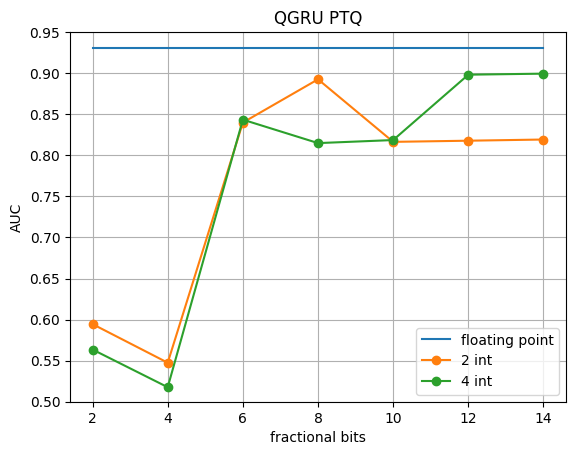

In [66]:
float_gru = [0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996, 0.9307736230093996]
plt.plot([2,4,6,8,10,12,14], float_gru, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], GRU_2intptq, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], GRU_4intptq, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU PTQ")
plt.grid()
plt.ylim([0.5, 0.95]) 

## QLSTM

In [64]:
lstm = load_model('lstm/model_toptag_lstm.h5')

In [65]:
LSTM_2intptq = []
LSTM_4intptq = []
for j in [2, 4]:
    for i in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = j
        total_bits = i + int_bits + 1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
    
        qmodel = model_quantize(lstm, config, total_bits, transfer_weights=True)
        
        labels = ['j_t']
        y_keras = qmodel.predict(x_test)
        auc_score = roc_auc_score(y_test, y_keras)
        print(auc_score)
        if j == 2:
            LSTM_2intptq.append(auc_score)
        else:
            LSTM_4intptq.append(auc_score)

624/624 [==============================] - 38s 59ms/step
0.6665990324916184
624/624 [==============================] - 38s 60ms/step
0.8023624335954
624/624 [==============================] - 38s 60ms/step
0.8400666269986702
624/624 [==============================] - 39s 60ms/step
0.7952402635228453
624/624 [==============================] - 38s 59ms/step
0.7864280430464492
624/624 [==============================] - 38s 60ms/step
0.7021665386943657
624/624 [==============================] - 39s 60ms/step
0.8316973148971215
624/624 [==============================] - 40s 61ms/step
0.6987813075380407
624/624 [==============================] - 39s 60ms/step
0.8234192235098241
624/624 [==============================] - 38s 59ms/step
0.8349360019909571
624/624 [==============================] - 38s 59ms/step
0.7193770394015198
624/624 [==============================] - 38s 59ms/step
0.8309812770112103
624/624 [==============================] - 39s 60ms/step
0.8152388047149924
624/624 [======

In [77]:
print(LSTM_2intptq)

[0.6665990324916184, 0.8023624335954, 0.8400666269986702, 0.7952402635228453, 0.7864280430464492, 0.7021665386943657, 0.8316973148971215]


In [79]:
LSTM_2intptq = [0.6665990324916184, 0.8023624335954, 0.8400666269986702, 0.7952402635228453, 0.7864280430464492, 0.7021665386943657, 0.8316973148971215]

In [78]:
print(LSTM_4intptq)

[0.6987813075380407, 0.8234192235098241, 0.8349360019909571, 0.7193770394015198, 0.8309812770112103, 0.8152388047149924, 0.8214026296810437]


In [80]:
LSTM_4intptq = [0.6987813075380407, 0.8234192235098241, 0.8349360019909571, 0.7193770394015198, 0.8309812770112103, 0.8152388047149924, 0.8214026296810437]

(0.5, 0.95)

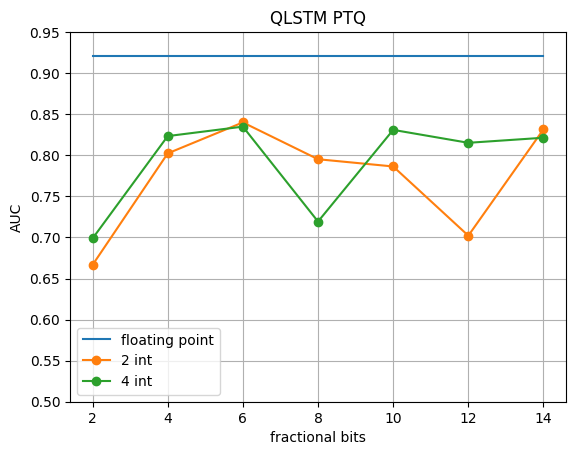

In [67]:
lstm_float = [0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558,0.9207847688802558]
plt.plot([2,4,6,8,10,12,14], lstm_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], LSTM_2intptq, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], LSTM_4intptq, "-o", label = '4 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM PTQ")
plt.grid()
plt.ylim([0.5, 0.95]) 